In [1]:
import os 
import pickle
import lmdb
from functools import lru_cache

class LMDBDataset:
    def __init__(self, db_path, split="train"):
        self.db_path = os.path.join(db_path, split+".lmdb")
        assert os.path.isfile(self.db_path), "{} not found".format(self.db_path)
        env = self.connect_db(self.db_path)
        self.dataset_size = int(env.begin().get("size".encode("ascii")).decode("ascii")) 

    def connect_db(self, lmdb_path, save_to_self=False):
        env = lmdb.open(
            lmdb_path,
            subdir=False,
            readonly=True,
            lock=False,
            readahead=False,
            meminit=False,
            max_readers=256,
        )
        if not save_to_self:
            return env
        else:
            self.env = env

    def __len__(self):
        return self.dataset_size

    @lru_cache(maxsize=16)
    def __getitem__(self, idx):
        if not hasattr(self, "env"):
            self.connect_db(self.db_path, save_to_self=True)
        datapoint_pickled = self.env.begin().get(f"{idx}".encode("ascii"))
        data = pickle.loads(datapoint_pickled)
        return data


dataset = LMDBDataset('data/graphs/BACE', split='train')
print(len(dataset))

663


In [2]:
n = min(100000, len(dataset))

def iterate_dataset(dataset):  
    for i in range(n):
        data = dataset[i]
        if isinstance(data, tuple):
            graph, target = data
        else:
            graph = data
        yield graph

In [3]:
atomic_num_count = {}
all_sizes = []

for graph in iterate_dataset(dataset):
    unique_atoms = set(graph['atom_atomic_nums'])
    for num in unique_atoms:
        if num not in atomic_num_count:
            atomic_num_count[num] = 0
        atomic_num_count[num] += 1
    all_sizes.append(len(graph['atom_atomic_nums']))
atomic_num_freq = {k: v/n for k, v in atomic_num_count.items()}
    

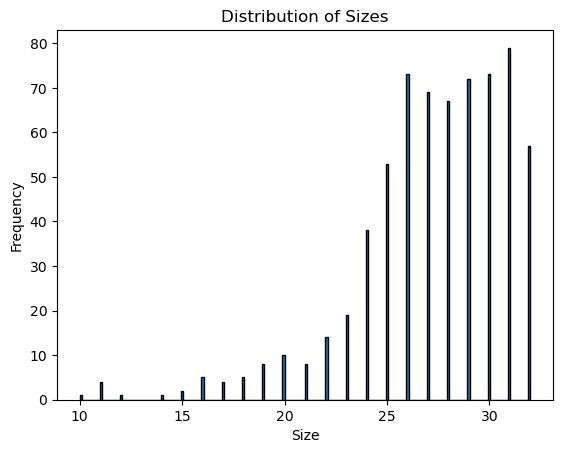

Max size: 32
Min size: 10
Average size: 27.206636500754147


In [4]:
import matplotlib.pyplot as plt

plt.hist(all_sizes, bins=200, edgecolor='black')
plt.title('Distribution of Sizes')
plt.xlabel('Size')
plt.ylabel('Frequency')
plt.show()

print('Max size:', max(all_sizes))
print('Min size:', min(all_sizes))
print('Average size:', sum(all_sizes) / len(all_sizes))

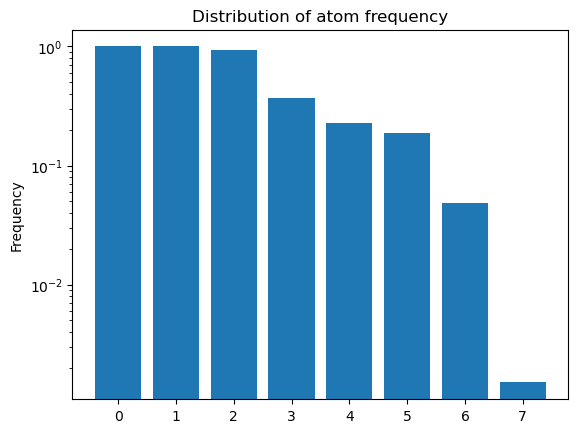

In [5]:
import numpy as np

freqs = [freq for freq in atomic_num_freq.values()]
freqs = sorted(freqs, reverse=True)

plt.bar(np.arange(len(freqs)),freqs, log=True)
plt.title('Distribution of atom frequency')
plt.ylabel('Frequency')
plt.show()

In [6]:
def get_k_most_frequent_atoms(k):
    sorted_atoms = sorted(atomic_num_freq.items(), key=lambda item: item[1], reverse=True)
    return [a for a, f in sorted_atoms[:k]]

def dataset_coverage(valid_atom_list):
    coverage = 0
    for graph in iterate_dataset(dataset):
        unique_atoms = set(graph['atom_atomic_nums'])
        if unique_atoms.issubset(valid_atom_list):
            coverage += 1
    return coverage/n

In [7]:
k = 8
# You can change this value to get a different number of most frequent atoms
most_frequent_atoms = get_k_most_frequent_atoms(k)
print('Most frequent atoms:', most_frequent_atoms)
print(most_frequent_atoms)

Most frequent atoms: [5, 6, 7, 15, 16, 8, 34, 14]
[5, 6, 7, 15, 16, 8, 34, 14]


In [7]:
PUBCHEM_top_8 = [5, 7, 6, 15, 16, 8, 34, 52]
PUBCHEM_top_16 = [5, 7, 6, 15, 16, 8, 34, 52, 14, 13, 4, 49, 10, 31, 77, 33]
PUBCHEM_top_32 = [5, 7, 6, 15, 16, 8, 34, 52, 14, 13, 4, 49, 10, 31, 77, 33, 28, 27, 26, 25, 12, 81, 50, 29, 32, 45, 41, 11, 0, 18, 24, 43]
PUBCHEM_top_64 = [5, 7, 6, 15, 16, 8, 34, 52, 14, 13, 4, 49, 10, 31, 77, 33, 28, 27, 26, 25, 12, 81, 50, 29, 32, 45, 41, 11, 0, 18, 24, 43, 82, 21, 79, 30, 19, 78, 2, 48, 22, 73, 42, 23, 37, 51, 76, 74, 3, 80, 71, 44, 46, 59, 47, 57, 91, 67, 69, 72, 63, 39, 40, 66]

for k, list in zip([8, 16, 32, 64], [PUBCHEM_top_8, PUBCHEM_top_16, PUBCHEM_top_32, PUBCHEM_top_64]):
    list = list[:-1]
    coverage = dataset_coverage(list)
    print(f'Graphs with [ukn] atom using dic size {k}: {100*(1-coverage):.2f}%')

Graphs with [ukn] atom using dic size 8: 0.15%
Graphs with [ukn] atom using dic size 16: 0.00%
Graphs with [ukn] atom using dic size 32: 0.00%
Graphs with [ukn] atom using dic size 64: 0.00%
